In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
np.random.seed(42)

n_schools = 5
n_students = 20
school_ids = np.repeat(np.arange(n_schools), n_students)

# Horas de estudo
horas_estudo = np.random.normal(5, 1.5, n_schools * n_students)

# Efeito aleatório no intercepto
interceptos = np.random.normal(0, 2, n_schools)

# Efeito aleatório na inclinação
slopes = np.random.normal(5, 1, n_schools)  # média 5 pontos por hora, mas varia por escola

# Nota por aluno
nota = []
for i, horas in zip(school_ids, horas_estudo):
    nota.append(50 + interceptos[i] + slopes[i] * horas + np.random.normal(0, 3))

nota = np.array(nota)

# DataFrame
df = pd.DataFrame({
    'nota': nota,
    'horas_estudo': horas_estudo,
    'escola': school_ids
})

df.head()


,nota,horas_estudo,escola
0,72.459602,5.745071,0
1,72.989190,4.792604,0
2,79.620416,5.971533,0
3,93.925035,7.284545,0
4,71.714365,4.648770,0


<Axes: xlabel='escola', ylabel='nota'>

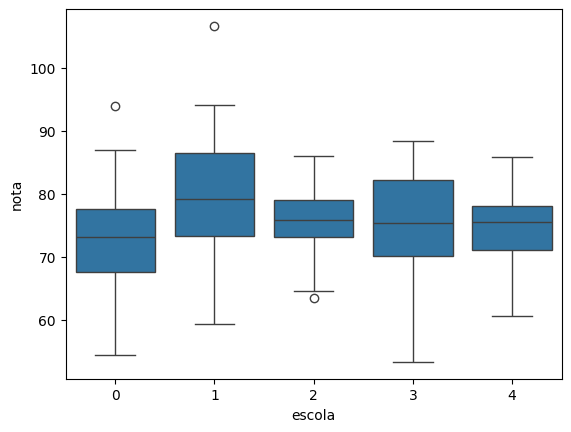

In [3]:
sns.boxplot(data=df, x='escola', y='nota')

<Axes: xlabel='horas_estudo', ylabel='nota'>

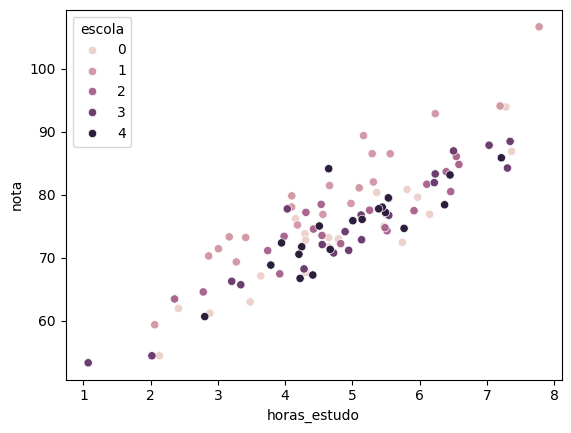

In [4]:
sns.scatterplot(data=df, x='horas_estudo', y='nota', hue='escola')

In [5]:
# Agora informamos random slopes:
# - 'groups' especifica os grupos (escola)
# - 're_formula' indica que queremos inclinação aleatória para horas_estudo
model = smf.mixedlm("nota ~ horas_estudo", data=df, groups=df["escola"], re_formula="~horas_estudo")
result = model.fit()

print(result.summary())

               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     nota     
No. Observations:     100         Method:                 REML     
No. Groups:           5           Scale:                  9.8312   
Min. group size:      20          Log-Likelihood:         -262.8111
Max. group size:      20          Converged:              Yes      
Mean group size:      20.0                                         
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                48.089    1.352 35.575 0.000 45.439 50.738
horas_estudo              5.714    0.381 14.985 0.000  4.967  6.462
Group Var                 1.413    2.155                           
Group x horas_estudo Cov  0.041    0.504                           
horas_estudo Var          0.424    0.171                       

In [6]:
# ---- Criando DataFrame com predições ----
horas_range = np.linspace(df['horas_estudo'].min(), df['horas_estudo'].max(), 50)
pred_list = []

In [7]:
for school in range(n_schools):
    re = result.random_effects[school]
    intercept_school = result.fe_params['Intercept'] + re.get('Intercept', 0)
    slope_school = result.fe_params['horas_estudo'] + re.get('horas_estudo', 0)
    
    pred_df = pd.DataFrame({
        'horas_estudo': horas_range,
        'nota_pred': intercept_school + slope_school * horas_range,
        'escola': school
    })
    pred_list.append(pred_df)

pred_all = pd.concat(pred_list)

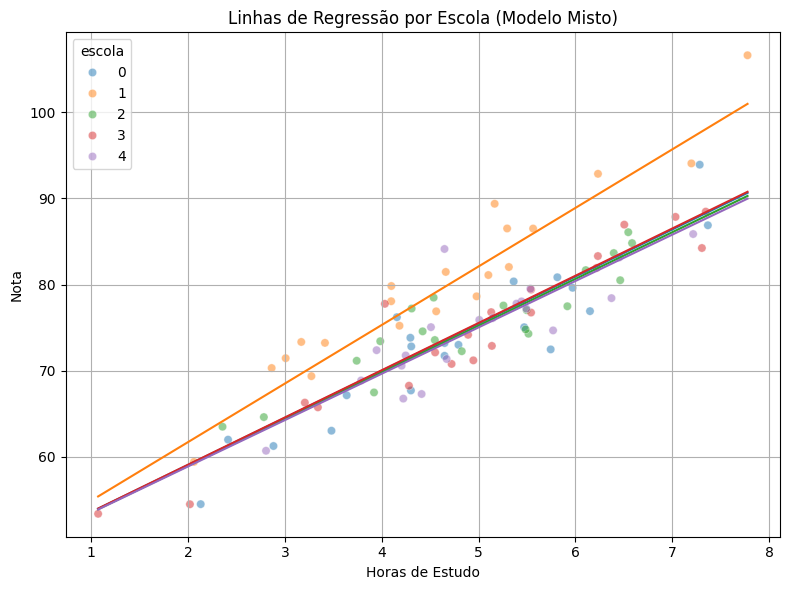

In [8]:
plt.figure(figsize=(8, 6))

# Pontos reais
sns.scatterplot(data=df, x='horas_estudo', y='nota', hue='escola', alpha=0.5, palette='tab10')

# Linhas previstas
sns.lineplot(data=pred_all, x='horas_estudo', y='nota_pred', hue='escola', palette='tab10', legend=False)

plt.xlabel("Horas de Estudo")
plt.ylabel("Nota")
plt.title("Linhas de Regressão por Escola (Modelo Misto)")
plt.grid(True)
plt.tight_layout()
plt.show()

## Deixando o dado um pouco mais interessante

In [9]:
# --- Extendendo o DataFrame com mais features ---
# Simulação de mais dados (apenas para exemplo)
np.random.seed(43) # outra seed para os novos dados

# Adicionar 5 novas features
df['idade'] = np.random.randint(15, 19, size=len(df))
df['genero'] = np.random.choice(['Masculino', 'Feminino'], size=len(df))
df['nivel_escolar'] = np.random.choice(['Fundamental', 'Médio', 'Superior'], size=len(df))
df['apoio_familiar'] = np.random.uniform(1, 10, size=len(df))
df['extracurricular_horas'] = np.random.uniform(0, 3, size=len(df))

# --- Adaptando o modelo misto com novas features ---
# Crie uma fórmula de modelo que inclua as novas features.
# Para variáveis categóricas, o statsmodels automaticamente cria variáveis dummy.
model_formula = "nota ~ horas_estudo + idade + genero + nivel_escolar + apoio_familiar + extracurricular_horas"

# Agora informamos os random slopes e interceptos
# A 're_formula' ainda indica que queremos inclinação aleatória para horas_estudo por escola.
# O novo modelo agora considera todas as variáveis fixas adicionadas.
model_extended = smf.mixedlm(model_formula, data=df, groups=df["escola"], re_formula="~horas_estudo")
result_extended = model_extended.fit()

print(result_extended.summary())

               Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     nota     
No. Observations:      100         Method:                 REML     
No. Groups:            5           Scale:                  10.1097  
Min. group size:       20          Log-Likelihood:         -260.8279
Max. group size:       20          Converged:              Yes      
Mean group size:       20.0                                         
--------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                 51.550    5.168  9.974 0.000 41.421 61.680
genero[T.Masculino]        0.566    0.661  0.856 0.392 -0.730  1.861
nivel_escolar[T.Médio]     0.338    0.799  0.423 0.672 -1.227  1.903
nivel_escolar[T.Superior] -0.567    0.787 -0.721 0.471 -2.109  0.975
horas_estudo               5.729    0.394 14.544 0

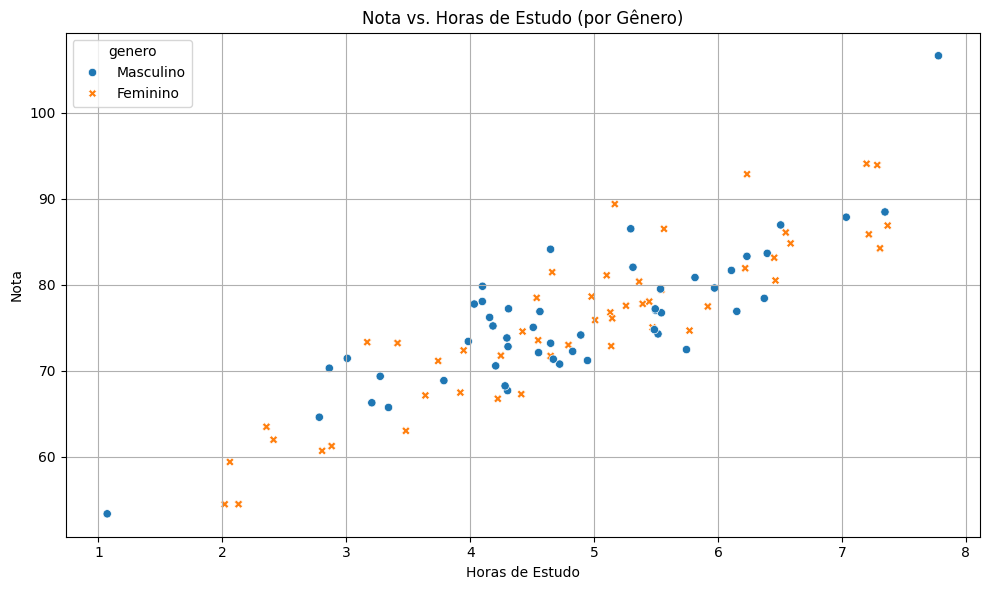

In [10]:
# Gráfico de dispersão: Nota vs. Horas de Estudo, com cor por Gênero
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='horas_estudo', y='nota', hue='genero', style='genero')
plt.title('Nota vs. Horas de Estudo (por Gênero)')
plt.xlabel('Horas de Estudo')
plt.ylabel('Nota')
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/wn/5t00gyl95g987w5nnw16f_x00000gn/T/ipykernel_7983/3714690262.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='nivel_escolar', y='nota', palette='viridis')


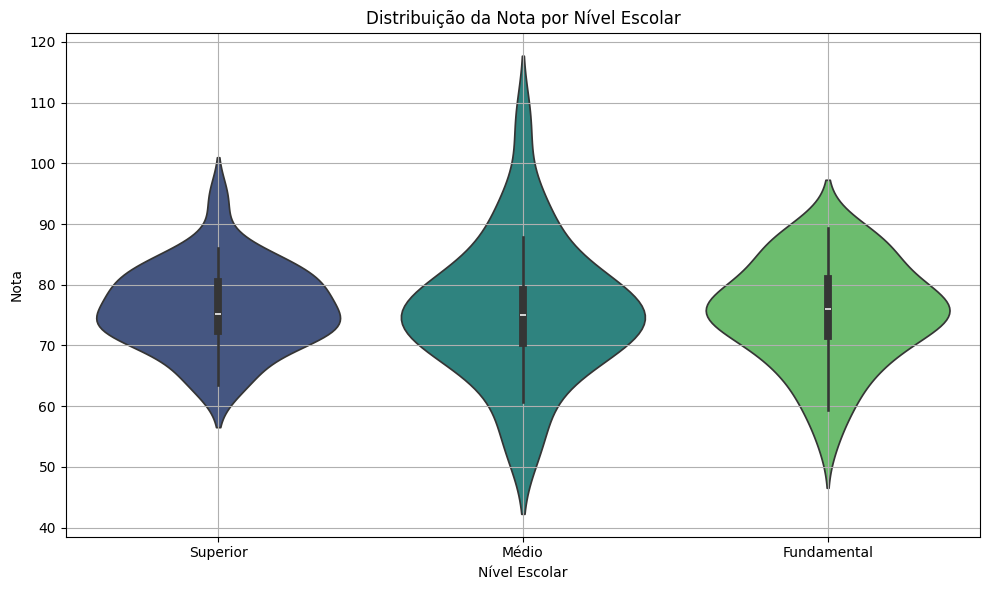

In [11]:
# Gráfico de violino: Distribuição da Nota por Nível Escolar
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='nivel_escolar', y='nota', palette='viridis')
plt.title('Distribuição da Nota por Nível Escolar')
plt.xlabel('Nível Escolar')
plt.ylabel('Nota')
plt.grid(True)
plt.tight_layout()
plt.show()

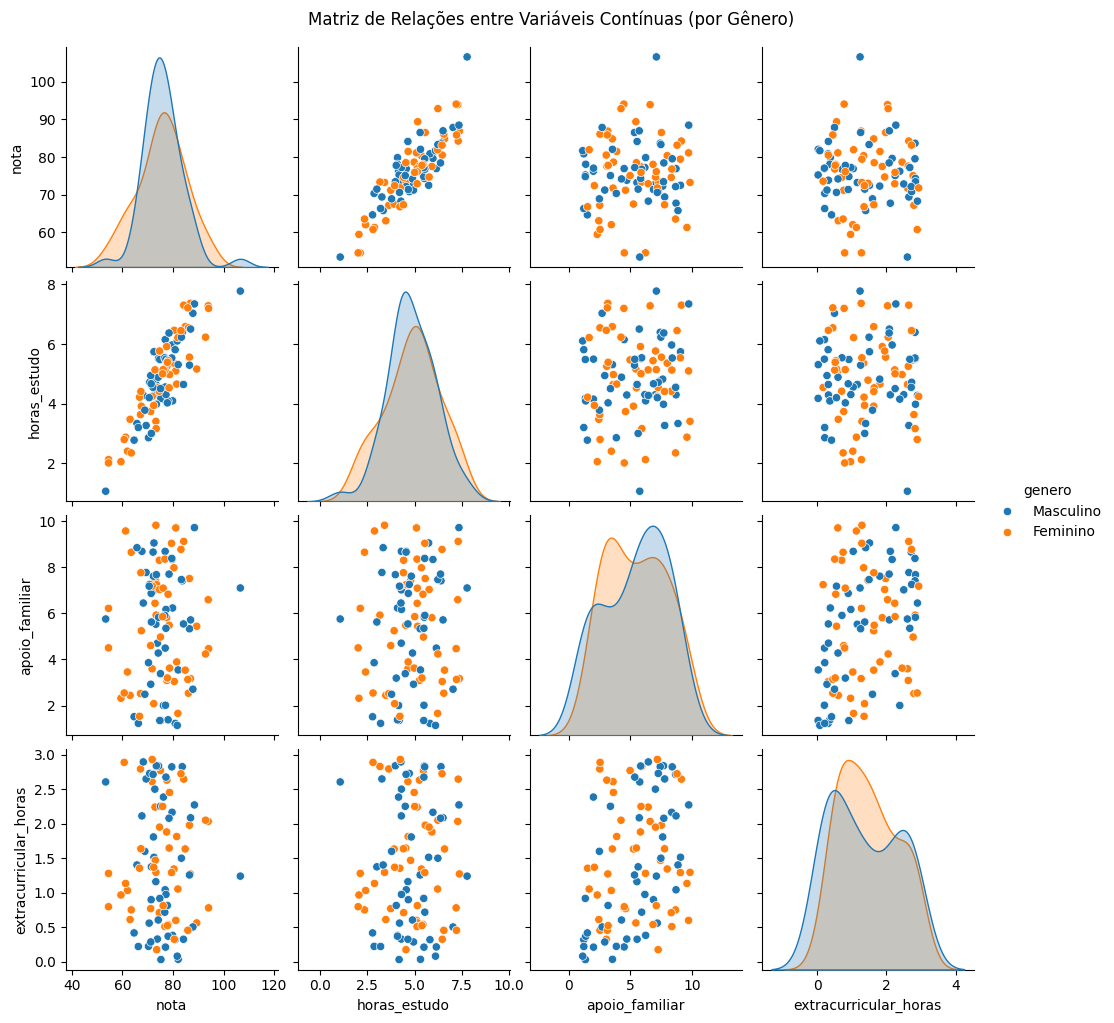

In [12]:
sns.pairplot(data=df, vars=['nota', 'horas_estudo', 'apoio_familiar', 'extracurricular_horas'], hue='genero')
plt.suptitle('Matriz de Relações entre Variáveis Contínuas (por Gênero)', y=1.02)
plt.show()

In [13]:
# Crie um DataFrame para as predições
horas_range = np.linspace(df['horas_estudo'].min(), df['horas_estudo'].max(), 50)
pred_list = []

# Obtenha os parâmetros fixos do modelo
fe_params = result_extended.fe_params

# Loop através de cada escola para calcular os interceptos e inclinações ajustados
for school in range(n_schools):
    # Obtenha os efeitos aleatórios para a escola atual
    re = result_extended.random_effects[school]

    # Calcule o intercepto e a inclinação aleatórios
    # O `get` é usado para garantir que o código funcione mesmo se não houver um efeito aleatório de inclinação
    intercept_school = fe_params['Intercept'] + re.get('Intercept', 0)
    slope_school = fe_params['horas_estudo'] + re.get('horas_estudo', 0)

    # Crie um DataFrame com as predições para a escola atual
    pred_df = pd.DataFrame({
        'horas_estudo': horas_range,
        'nota_pred': intercept_school + slope_school * horas_range,
        'escola': school
    })
    pred_list.append(pred_df)

# Concatene todos os DataFrames de predição em um só
pred_all = pd.concat(pred_list)

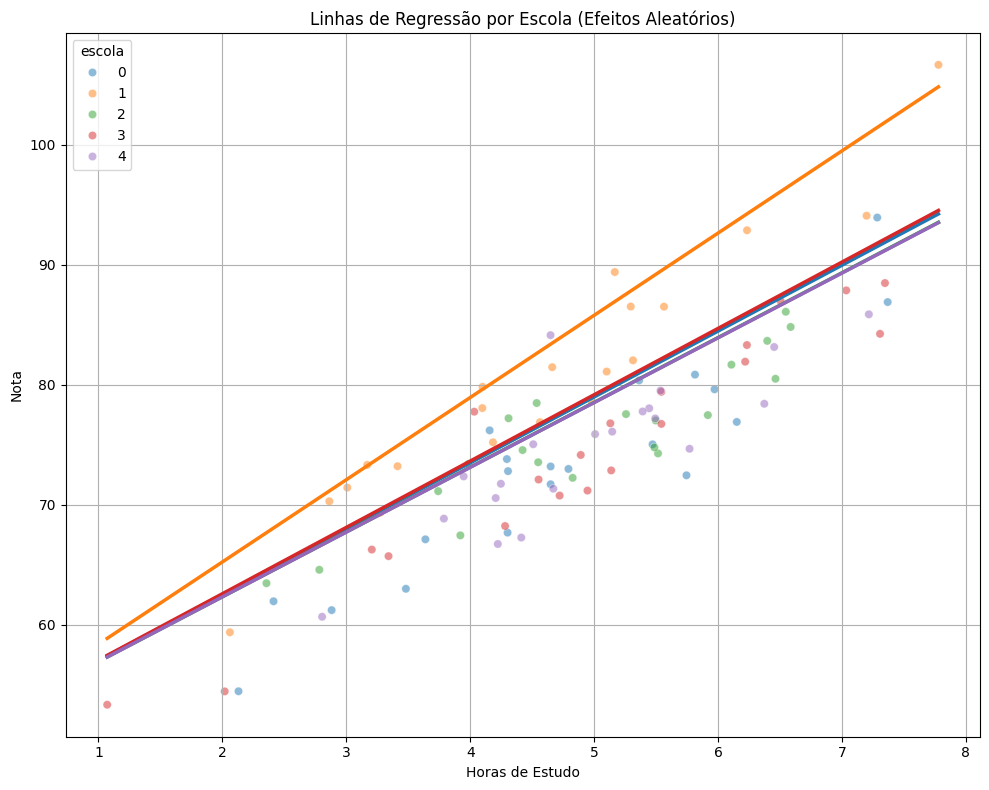

In [14]:
# --- Visualizando as linhas de regressão (efeitos aleatórios) ---
plt.figure(figsize=(10, 8))

# Pontos reais
sns.scatterplot(data=df, x='horas_estudo', y='nota', hue='escola', alpha=0.5, palette='tab10')

# Linhas previstas
sns.lineplot(data=pred_all, x='horas_estudo', y='nota_pred', hue='escola', palette='tab10', legend=False, linewidth=2.5)

plt.xlabel("Horas de Estudo")
plt.ylabel("Nota")
plt.title("Linhas de Regressão por Escola (Efeitos Aleatórios)")
plt.grid(True)
plt.tight_layout()
plt.show()